num points:  767399
seconds:  3.9968697916666667


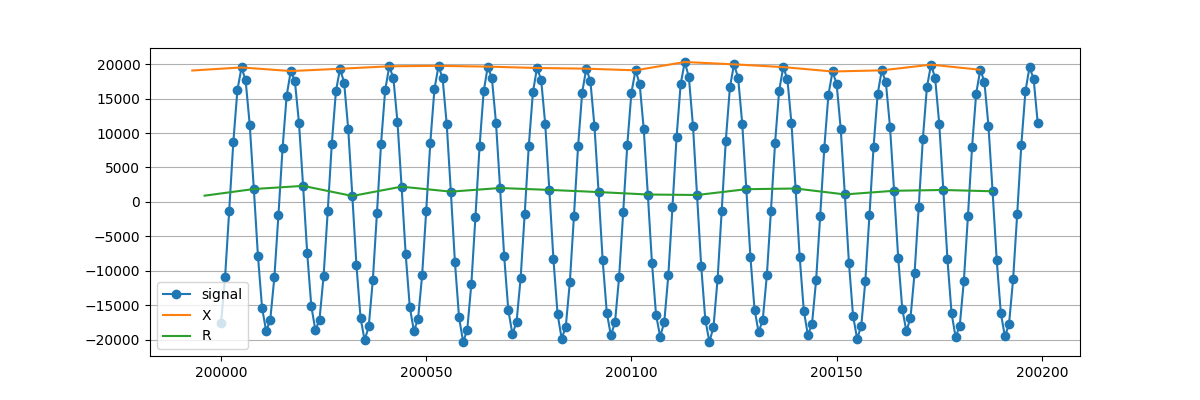

In [1]:
%matplotlib widget
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import math
from ipywidgets import interact, FloatSlider, IntSlider, Layout
import scipy.signal as signal

plt.rcParams['figure.figsize'] = [12, 4]
plt.rcParams['figure.dpi'] = 100 # 200 e.g. is really fine, but slower

sampleRate = 192000
frequency = 16000

#filename = "2022_03_09 10_08_58 MST 192000 SPS 8000.0 Hz 20 vol playing.txt"
#filename = "2022_02_25 17_57_52 MST 192000 SPS 16000.0 Hz 20 vol playing (air).txt"
filename = "2022_02_25 17_58_33 MST 192000 SPS 16000.0 Hz 20 vol playing (quarter).txt"

signalData = pd.read_csv(filename, header=None).to_numpy()[:,0]
#there is a weird phase blip after the first ~500 points (seems to happen in every recording?? double check this), discard these data for consistency
signalData = signalData[600:-1]
numPoints = signalData.shape[0]
xPoints = np.arange(0, numPoints)

print("num points: ", numPoints)
print("seconds: ", numPoints/sampleRate)

#the offset before sampling X
offsetInSamples = 1

fig = plt.figure()
graphStartIndex = 200000
graphWindowSize = 200
plt.plot(xPoints[graphStartIndex:graphStartIndex + graphWindowSize], signalData[graphStartIndex:graphStartIndex + graphWindowSize], marker='o', label="signal")
plt.grid(visible='true', which='major', axis='y')

periodInSamples = int(round(sampleRate * 1.0 / frequency, 0))
quarterPeriodInSamples = int(round(math.pi/2 / (2*math.pi) * sampleRate * 1.0 / frequency, 0))

signalXIndicesList = []
signalXList = []
for i in range(offsetInSamples, numPoints, periodInSamples):
    signalXList.append(signalData[i])
    signalXIndicesList.append(i)
signalX = np.asarray(signalXList)
signalXIndices = np.asarray(signalXIndicesList)

signalRIndicesList = []
signalRList = []
for i in range(offsetInSamples + quarterPeriodInSamples, numPoints, periodInSamples): 
    signalRList.append(signalData[i])
    signalRIndicesList.append(i)
    #if ((i+1) < numPoints):
    #    factor = 0.85
    #    signalRList.append((signalData[i] * factor + signalData[i+1]*(1-factor)) / 2)
    #    signalRIndicesList.append(i)
signalR = np.asarray(signalRList)
signalRIndices = np.asarray(signalRIndicesList)

#make arrays the same size
if (signalR.size != signalX.size):
    minSize = min([signalR.size, signalX.size])
    signalR = signalR[0:minSize-1]
    signalRIndices = signalRIndices[0:minSize-1]
    signalX = signalX[0:minSize-1]
    signalXIndices = signalXIndices[0:minSize-1]

XRStartIndex = int(graphStartIndex/periodInSamples)
XRRange = int(graphWindowSize/periodInSamples)+1
plt.plot(signalXIndices[XRStartIndex:XRStartIndex + XRRange], signalX[XRStartIndex:XRStartIndex + XRRange], label="X")
plt.plot(signalRIndices[XRStartIndex:XRStartIndex + XRRange], signalR[XRStartIndex:XRStartIndex + XRRange], label="R")
plt.legend()

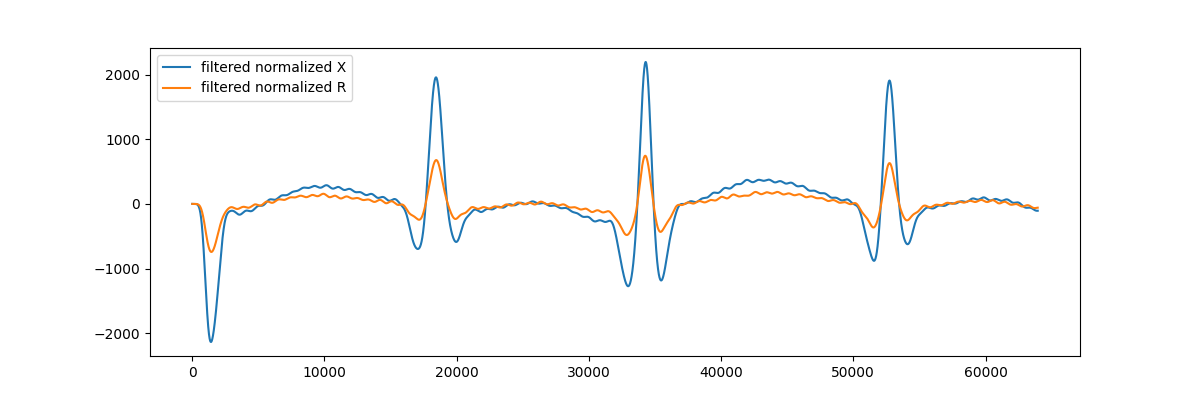

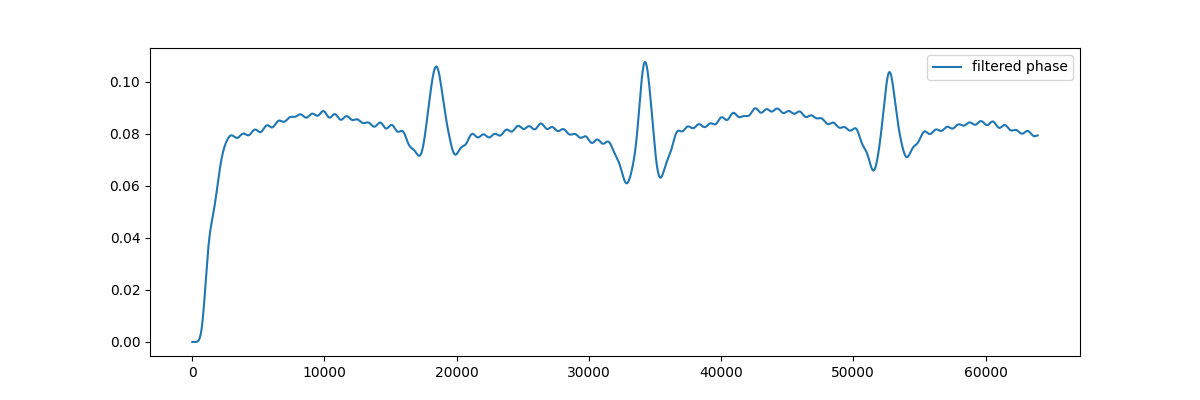

In [2]:
normalizedX = signalX - np.average(signalX)
#shouldn't need to normalize R if offset properly, but maybe worth doing in case it's a little off
normalizedR = signalR - np.average(signalR)

#do I take the difference before or after filtering?
#phaseRad = np.unwrap(np.angle(analyticSignalFilt))

firFilter = signal.firwin(2001, cutoff = 100, window = "blackmanharris", pass_zero = "lowpass", fs=sampleRate)
filteredX = signal.lfilter(firFilter, 1, normalizedX)
filteredR = signal.lfilter(firFilter, 1, normalizedR)
fig = plt.figure()
plt.plot(filteredX, label="filtered normalized X")
plt.plot(filteredR, label="filtered normalized R")
plt.legend()

fig = plt.figure()
phase = np.unwrap(np.arctan2(signalR, signalX))
phaseFiltered = signal.lfilter(firFilter, 1, phase)
plt.plot(phaseFiltered, label="filtered phase")
plt.legend()

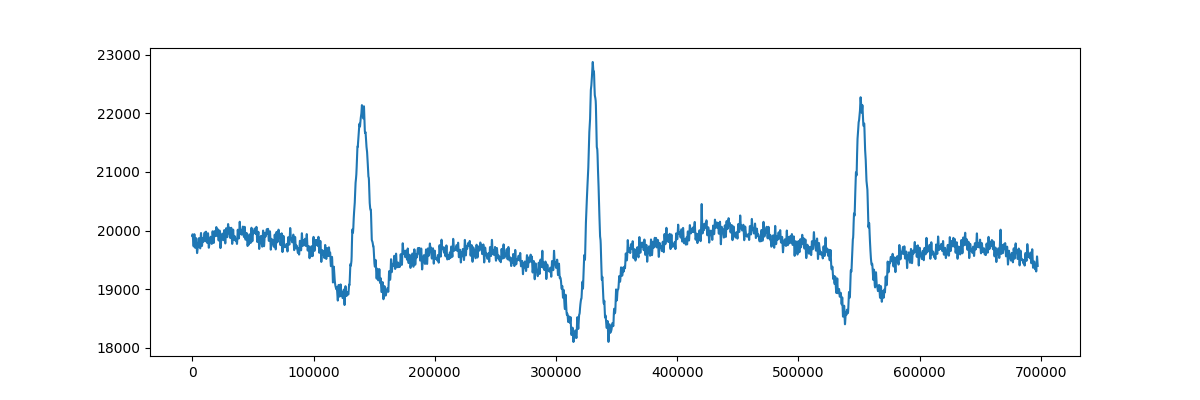

In [3]:
analytic_signal = signal.hilbert(signalData)#returns array of imaginary numbers, where real = I (in-phase) and imaginary = Q (quadrature, 90 deg out of phase)
amplitude_envelope = np.abs(analytic_signal)
instantaneous_phase = np.unwrap(np.angle(analytic_signal))#this gives a continuously increasing phase angle in radians (somehow), that doesn't wrap when the period ends
instantaneous_frequency = (np.diff(instantaneous_phase) /
                           (2.0*np.pi) * sampleRate)

amplitude_envelope = signal.lfilter(firFilter, 1, amplitude_envelope)
fig = plt.figure()
plt.plot(amplitude_envelope[70000:-1])